In [1]:
from IPython.core.display import HTML
from IPython.lib.display import YouTubeVideo
from IPython.display import Image

def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import json

# Introduction

For my final project, I am using RNA-Seq differential mRNA data (Ricarte-Filho et al., 2013) to identify kinase fusion oncogenes playing key-roles in the gene expression underlying post-Chernobyl radiation-induced pediatric thyroid carcinomas (TC). By studying the gene expression of over 25000 genes, I hope to highlight the up- and down-regulated genes within this tumor as well as narrow down the pathways involved in these processes.

It has been reported that genetic alterations in the receptor tyrosine kinases (RTKs) and P13K/Akt and MAPK pathways are extremely prevalent in both anaplastic and follicular TC (Liu et al., 2008). Thus, the development of therapies targeting these pathways requires an extensive search into the specific genes underlying the changes promoting oncogenic phenotypes.

# Data Analysis

## Confirming Key Pathways

First we will be confirming which pathways are most up- and down-regulated in the dataset utilizing the gene set enrichment analysis (GSEA) method along with the KEGG pathway functional database on WebGestalt. This is done to start out our search of pathways to focus on as well as get a general sense of the effects of pediatric TC.

In [2]:
fold_df = pd.read_csv('chernobyl_analytics.tsv', sep='\t')
fold_df = fold_df[fold_df["Gene Name"].notnull()]
#fold_df = fold_df[fold_df["'papillary thyroid carcinoma' vs 'normal'.p-value"].notnull()]
fold_df = fold_df[fold_df["'papillary thyroid carcinoma' vs 'normal'.log2foldchange"].notnull()]
fold_df

,Gene ID,Gene Name,'papillary thyroid carcinoma' vs 'normal'.p-value,'papillary thyroid carcinoma' vs 'normal'.log2foldchange
0,ENSG00000000003,TSPAN6,0.775035,-0.2
1,ENSG00000000005,TNMD,NaN,-0.6
2,ENSG00000000419,DPM1,0.521120,-0.1
3,ENSG00000000457,SCYL3,0.714454,0.2
4,ENSG00000000460,C1orf112,0.495302,0.2
...,...,...,...,...
58713,ENSG00000285972,CERNA2,NaN,0.3
58716,ENSG00000285975,FAM90A7P,NaN,0.0
58725,ENSG00000285985,LINC02689,NaN,0.0
58729,ENSG00000285989,H2AQ1P,NaN,0.0


In [3]:
fold_df_slice = fold_df[["Gene Name", "'papillary thyroid carcinoma' vs 'normal'.log2foldchange"]].dropna()
fold_df_slice.to_csv('chern_tc_fc.rnk', index=False, header=False, sep='\t')

In [4]:
# Most Upregulated
# 1) hsa04650: Natural killer cell mediated cytotoxicity (NES = 1.8662)
# 2) hsa05150: Staphylococcus aureus infection (NES = 1.7967)
# 3) hsa05320: Autoimmune thyroid disease (NES = 1.7433)

# Most Downregulated
# 1) hsa00053: Ascorbate and aldarate metabolism (NES = -1.2084)
# 2) hsa00750: Vitamin B6 metabolism (NES = -1.0648)
# 3) hsa00120: Primary bile acid biosynthesis (NES = -1.0309)

This analysis has shown us the importance of the immune system in this study as these pathways are highly upregulated in post-Chernobyl radiation-induced pediatric TCs compared to the control. It is important to note that MAPKs are essential regulators in both the innate and the adaptive immune responses (Liu et al., 2007) while the PI3K/Akt pathway defects lead to autoimmune or immunodeficiency and immune dysregulation phenotypes (Nunes-Santos et al., 2019). With this, it is important to delve deeper into the set of genes in the PI3K, Akt, and MAPK pathways in addition to the general thyroid cancer pathway to get a better understanding of gene expression changes across conditions.


## Gene Clustering

With these results, we can perform hierarchial clustering to understand which samples are best suited to be studied.

/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/541250122.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design['labels'].loc[(design['Factor Value[disease]'].values == "papillary thyroid carcinoma")] = 'PTC'
/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/541250122.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design['labels'].loc[(design['Factor Value[disease]'].values == "normal")] = 'NORM'
/Users/sammymustafa/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3903: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined

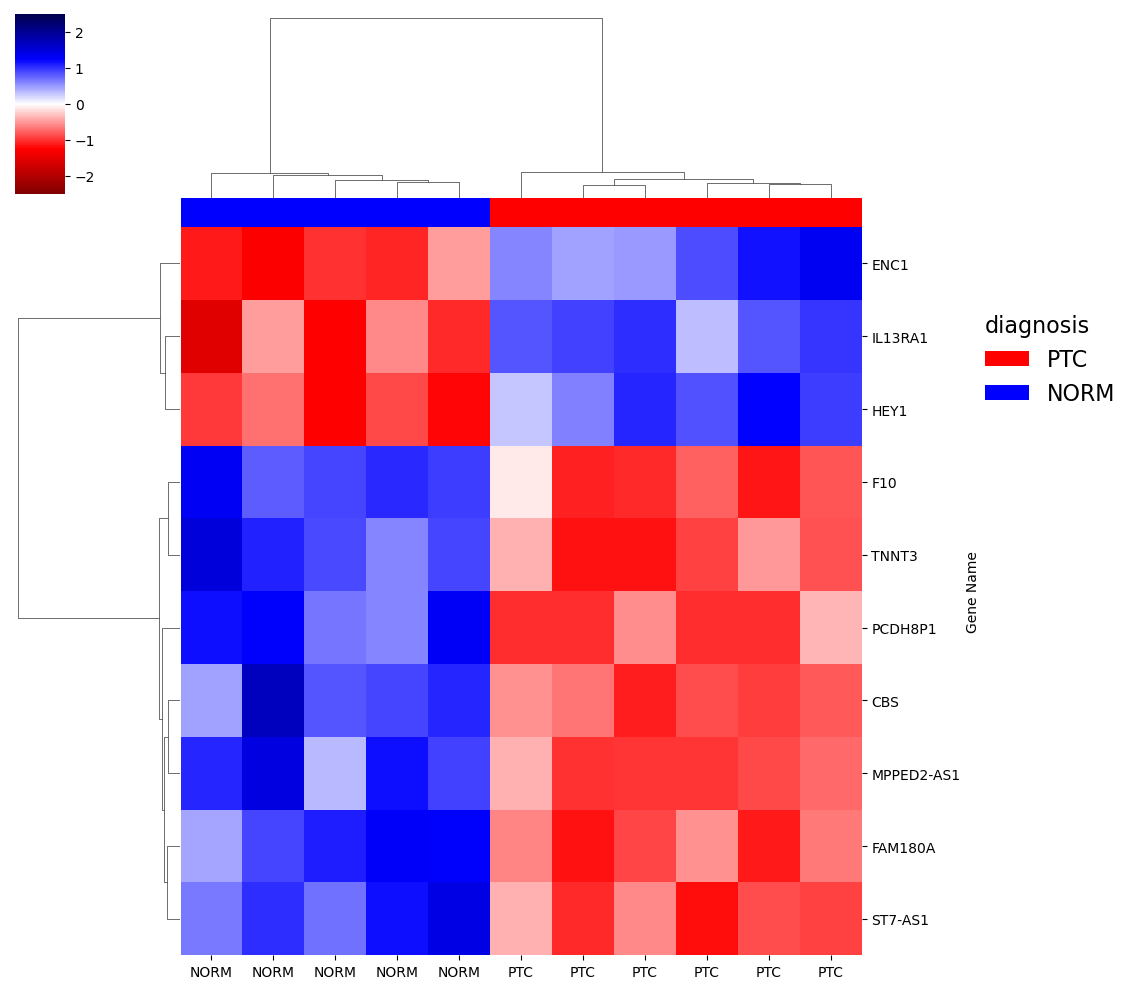

In [5]:
def get_tmm(counts, ref_col, test_col, trim_m=0.30, trim_a=0.05):

    '''
        Calculates TMM value between ref_col and test_col
        
        counts = count matrix (pd.DataFrame)
        ref_col = reference column (str)
        test_col = test columns (str)
        trim_m = extremes to trim when taking trimmed mean of M values (float)
        trim_a = extremes to trim when taking trimmed mean of M values (float)
        
    '''

    if ref_col == test_col:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col]]
    else:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col, test_col]]

    n_k = counts_slim[test_col].sum()
    n_r = counts_slim[ref_col].sum()

    m_k = np.log2(counts_slim[test_col].values/n_k)-np.log2(counts_slim[ref_col].values/n_r)
    a_k = 0.5*np.log2((counts_slim[test_col].values/n_k)*(counts_slim[ref_col].values/n_r))
    w_k = (n_k - counts_slim[test_col].values)/(n_k*counts_slim[test_col].values) + (n_r - counts_slim[ref_col].values)/(n_r*counts_slim[ref_col].values)

    trim_array_m = (m_k <= np.percentile(m_k, 100*(1-(trim_m/2)))) & ((m_k >= np.percentile(m_k, 100*((trim_m/2)))))
    trim_array_a = (a_k <= np.percentile(a_k, 100*(1-(trim_a/2)))) & ((a_k >= np.percentile(a_k, 100*((trim_a/2)))))

    m_k = m_k[trim_array_m & trim_array_a]
    a_k = a_k[trim_array_m & trim_array_a]
    w_k = w_k[trim_array_m & trim_array_a]
    tmm_k = 2**(np.sum(w_k*m_k)/np.sum(w_k))
    return tmm_k

def get_m_a(counts, ref_col, test_col, trim_m=0.30, trim_a=0.05):

    '''
        Calculates TMM value between ref_col and test_col
        
        counts = count matrix (pd.DataFrame)
        ref_col = reference column (str)
        test_col = test columns (str)
        trim_m = extremes to trim when taking trimmed mean of M values (float)
        trim_a = extremes to trim when taking trimmed mean of M values (float)
        
    '''

    if ref_col == test_col:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col]].copy()
    else:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col, test_col]]

    n_k = 1 #counts_slim[test_col].sum()
    n_r = 1 #counts_slim[ref_col].sum()

    m_k = np.log2(counts_slim[test_col].values/n_k)-np.log2(counts_slim[ref_col].values/n_r)
    a_k = 0.5*np.log2((counts_slim[test_col].values/n_k)*(counts_slim[ref_col].values/n_r))
    return m_k, a_k

def norm_tmm(counts, columns_to_norm, ref_col=None):
    '''
        Normalizes count matrix by TMM.
        
        counts = count matrix (pd.DataFrame)
        ref_col = reference column (str)
        columns_to_norm = columns to be normed (str)
        
    '''
    if ref_col == None:
        ref_col = columns_to_norm[0]
    counts[counts.columns[~counts.columns.isin(cols_to_norm)]]
        
    tmm_array = []
    for col in columns_to_norm:
        tmm_array.append(get_tmm(counts = counts, ref_col=ref_col, test_col=col))
    tmm_array = np.array(tmm_array)
    #print(tmm_array)

    norm_counts = counts[columns_to_norm]/(np.sqrt(tmm_array)*counts[columns_to_norm].sum(axis=0))
    norm_counts[counts.columns[~counts.columns.isin(columns_to_norm)]] = counts[counts.columns[~counts.columns.isin(columns_to_norm)]]
    return norm_counts

counts = pd.read_csv('chernobyl_raw_counts.tsv', sep='\t')
counts = counts[counts["Gene Name"].notnull()]
design = pd.read_csv('experiment_design.tsv', sep='\t')
design = design[design['Analysed'] == 'Yes'].reset_index(drop=True)

design['labels'] = ['']*len(design)

design['labels'].loc[(design['Factor Value[disease]'].values == "papillary thyroid carcinoma")] = 'PTC'
design['labels'].loc[(design['Factor Value[disease]'].values == "normal")] = 'NORM'

design = design.sort_values('labels')
cols_to_norm = design['Run'].values
labels = design['labels'].values

counts_norm = counts.copy()

counts_norm = norm_tmm(counts_norm, columns_to_norm=cols_to_norm, ref_col=cols_to_norm[0])

a = counts_norm[cols_to_norm].values[:,labels == 'PTC']
b = counts_norm[cols_to_norm].values[:,labels == 'NORM']
counts_norm['ttest_p'] = scipy.stats.f_oneway(a.T, b.T).pvalue
counts_norm = counts_norm.dropna(subset=['ttest_p'])
counts_norm['bonferroni_fwer'] = counts_norm['ttest_p']*len(counts_norm['ttest_p'])
counts_norm['bonferroni_fwer'][counts_norm['bonferroni_fwer'] > 1] = 1.0
counts_norm['bh_fdr'] = counts_norm['ttest_p']*len(counts_norm['ttest_p'])/counts_norm['ttest_p'].rank()
counts_norm['bh_fdr'][counts_norm['bh_fdr'] > 1] = 1.0

counts_norm_slim = counts_norm[counts_norm['bonferroni_fwer'] < 0.5]
counts_norm_slim = counts_norm_slim.set_index('Gene Name')[cols_to_norm]
counts_norm_slim.columns = labels

# Define colors to label our columns to make the diagnosis categories of our clustermap easier to read
lut = dict(zip(set(labels), ['r', 'b'])) # red, blue
col_colors = pd.DataFrame(labels)[0].map(lut)

g = sns.clustermap(counts_norm_slim, # data to cluster
                   method='ward', # method for heiarchical clustering
                   col_cluster=True, # cluster columns
                   z_score=0, # axis to perform z standardization
                   vmin=-2.5, vmax=2.5, # upper and lower limits of our colorbar
                   cmap='seismic_r', # palette to use for our colorbar
                   col_colors=[col_colors]) # what colors to label our columns on the margin

# define legend for col colors
ax = g.ax_heatmap
handles1 = [mpl.patches.Patch(facecolor=lut[name]) for name in lut]

leg1 = g.ax_row_dendrogram.legend(handles1, lut, title='diagnosis',
           bbox_to_anchor=(0.97, 0.70), bbox_transform=plt.gcf().transFigure, loc='upper left', frameon=False, fontsize=16)
plt.setp(leg1.get_title(),fontsize=16)
leg1._legend_box.align = "left"

With this clustering, we can select four normal and four pediatric thyroid carcinoma samples to try to account for the variation across the samples and have a more efficient analysis of gene expression.


## Gene Counts

First we need to load the raw gene expression experiment data for the normal vs post-Chernobyl radiation-induced pediatric TCs. With this data overlooking 25000 genes after processing, we can uncover the fold changes of the genes in each respective pathway and see how they compare. This can highlight specific genes and/or pathways that can be targeted for future therapeutics.

In [6]:
counts_df = pd.read_csv('chernobyl_raw_counts.tsv', sep = '\t')
counts_df = counts_df.set_index('Gene Name')
counts_df = counts_df[counts_df.index.notnull()]
counts_df.rename(columns = {'SRR934360':'control_SRR934360', 'SRR934361':'control_SRR934361', 'SRR934362':'control_SRR934362', 'SRR934363':'control_SRR934363', 'SRR934364':'control_SRR934364', 'SRR934365':'carc_SRR934365', 'SRR934366':'carc_SRR934366', 'SRR934367':'carc_SRR934367', 'SRR934368':'carc_SRR934368', 'SRR934369':'carc_SRR934369', 'SRR934370':'carc_SRR934370'}, inplace = True)
counts_df = counts_df.drop(columns = ['Gene ID', 'control_SRR934360', 'carc_SRR934365', 'carc_SRR934368'])
sample_names = counts_df.columns

# label our data
labels = np.array(['control']*4 + ['carc']*4)
# take our control and carcinoma data
control_vals = counts_df[sample_names[labels == 'control']].values
treatment_vals = counts_df[sample_names[labels == 'carc']].values
# perform a t-test
counts_df['ttest_p'] = scipy.stats.ttest_ind(control_vals.T,treatment_vals.T, equal_var=False).pvalue
# calculate log2 fold change
counts_df['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))

counts_df = counts_df.replace([np.inf, -np.inf], np.nan)
counts_df = counts_df[counts_df["log2FC"].notnull()]
counts_df

/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/3140025922.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  counts_df['ttest_p'] = scipy.stats.ttest_ind(control_vals.T,treatment_vals.T, equal_var=False).pvalue
/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/3140025922.py:16: RuntimeWarning: divide by zero encountered in true_divide
  counts_df['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))
/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/3140025922.py:16: RuntimeWarning: invalid value encountered in true_divide
  counts_df['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))
/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/3140025922.py:16: RuntimeWarning: divide by zero encountered in log2
  counts_df['log2FC'] = np.log2(np.me

,carc_SRR934366,control_SRR934364,carc_SRR934370,control_SRR934361,control_SRR934362,control_SRR934363,carc_SRR934367,carc_SRR934369,ttest_p,log2FC
Gene Name,,,,,,,,,,
TSPAN6,1371,2416,1052,1534,3463,3417,2257,3492,0.009715,0.986696
TNMD,1,1,0,1,5,1,1,0,0.438232,1.222392
DPM1,614,1205,663,673,2126,1309,1207,976,0.087929,0.832417
SCYL3,253,494,319,370,694,760,707,684,0.003818,0.986373
C1orf112,50,119,59,69,146,102,140,99,0.054871,0.713459
...,...,...,...,...,...,...,...,...,...,...
ANAPC1P2,1,9,3,7,11,11,3,2,0.590470,0.432959
GET1-SH3BGR,2,0,0,0,1,0,0,4,0.517686,1.321928
CCDC15-DT,3,22,4,13,24,26,17,39,0.046327,1.335603




## PI3K Pathway

First, we can dive deeper into the expression of the genes involved in the PI3K pathway. This list of oncogenes was obtained from the Pathway Interaction Database (PID) and includes major genes involved in the pathway like FOXO3, IL2, and MYC among other notable gene modulators. 

In [7]:
pi3k_json = json.load(open('pathways/PID_IL2_PI3K_PATHWAY.v2023.1.Hs.json'))
pi3k_genes = []

for gene in pi3k_json['PID_IL2_PI3K_PATHWAY']['geneSymbols']:
    pi3k_genes.append(gene)

pi3k_genes = ['HSP90AA1', 'PIK3CA', 'LCK', 'MYC', 'MYB', 'BCL2', 'AKT1',
              'PTPN11', 'FOX03', 'JAK3', 'IL2', 'JAK1']

Since the enrichment score 0.2969746192893611 is positive, we are studying the upregulated genes from the PI3K pathway.


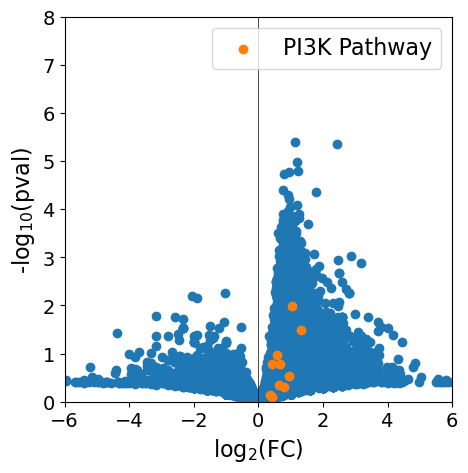

In [8]:
counts_df_sorted = counts_df.sort_values('log2FC', ascending=False)
barcode = counts_df_sorted.index.isin(pi3k_genes)

fig = plt.figure(figsize=(5,5))
plt.scatter(counts_df['log2FC'], -np.log10(counts_df['ttest_p']))
counts_df_slice = counts_df[counts_df.index.isin(pi3k_genes)]
plt.scatter(counts_df_slice['log2FC'], -np.log10(counts_df_slice['ttest_p']), label='PI3K Pathway')

ax = plt.gca()
ax.set_xlim([-6,6])
ax.set_ylim([0,8])
ax.legend(fontsize=16)
ax.axvline(0, color='k', linewidth=0.5)
ax.tick_params(labelsize=14) # set the fontsize of the tick labels
ax.set_xlabel(r'log$_2$(FC)', fontsize=16)
ax.set_ylabel(r'-log$_{10}$(pval)', fontsize=16)

# enrichment score
running_sum_storage = []
running_sum = 0
running_sum_storage.append(running_sum)
n_in_pathway = np.sum(barcode)
n_not_in_pathway = len(barcode) - np.sum(barcode)
for ele in barcode:
    if ele: # gene is in gene set
        running_sum += 1/n_in_pathway
    else: # gene is not in gene set
        running_sum -= 1/n_not_in_pathway
    running_sum_storage.append(running_sum)
running_sum_storage = np.array(running_sum_storage)

es_true = running_sum_storage[np.argmax(np.abs(running_sum_storage))]
print("Since the enrichment score", es_true, "is positive, we are studying the upregulated genes from the PI3K pathway.")

/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/2226727879.py:13: RuntimeWarning: divide by zero encountered in true_divide
  counts_df_1['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))
/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/2226727879.py:13: RuntimeWarning: divide by zero encountered in log2
  counts_df_1['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))


The empirical p-value of 0.5329087048832272 is above the 0.05 threshold, meaning that the set of PI3K genes are not all significantly upregulated in post-Chernobyl radiation-induced pediatric thyroid cancers.


/Users/sammymustafa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


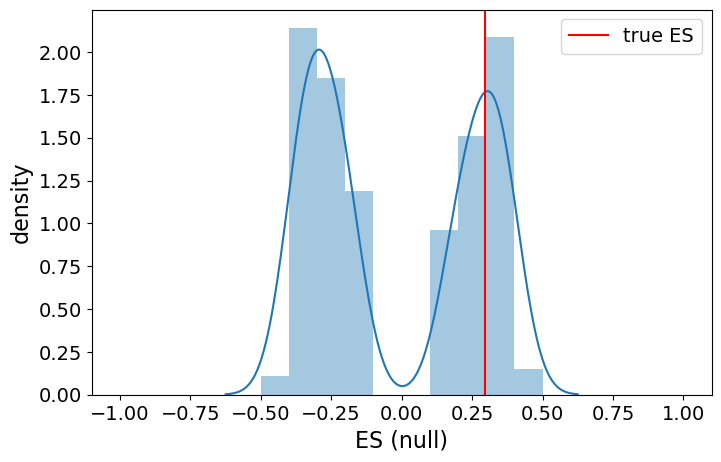

In [9]:
np.random.seed(1701)

n_permutations = 1000
es_null_storage_array = []
for permute_n in range(n_permutations):
    new_labels = np.random.permutation(labels)

    control_vals = counts_df[sample_names[new_labels == 'control']].values
    treatment_vals = counts_df[sample_names[new_labels == 'carc']].values

    # calculate log2 fold change
    counts_df_1 = counts_df.copy()
    counts_df_1['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))
    counts_df_1 = counts_df_1.replace([np.inf, -np.inf], np.nan)
    counts_df_1 = counts_df_1[counts_df_1["log2FC"].notnull()]
    counts_df_1_sorted = counts_df_1.sort_values('log2FC', ascending=False)

    barcode = counts_df_1_sorted.index.isin(pi3k_genes)

    running_sum_storage = []
    running_sum = 0
    running_sum_storage.append(running_sum)
    n_in_pathway = np.sum(barcode)
    n_not_in_pathway = len(barcode) - np.sum(barcode)
    for ele in barcode:
        if ele: # gene is in gene set
            running_sum += 1/n_in_pathway
        else: # gene is not in gene set
            running_sum -= 1/n_not_in_pathway
        running_sum_storage.append(running_sum)
    running_sum_storage = np.array(running_sum_storage)
    # get value of max deviation from zero
    es_null_storage_array.append(running_sum_storage[np.argmax(np.abs(running_sum_storage))])

es_null_storage_array = np.array(es_null_storage_array)

plt.figure(figsize=(8,5))
sns.distplot(es_null_storage_array, bins=np.arange(-1,1.01,0.1))

ax = plt.gca()
ax.axvline(es_true, color='r', label='true ES')
ax.legend(fontsize=14)
ax.set_xlabel('ES (null)', fontsize=16)
ax.set_ylabel('density', fontsize=16)
ax.tick_params(labelsize=14)

pos_es = es_null_storage_array[es_null_storage_array > 0] # get array of positive enrichment scores
print("The empirical p-value of", np.sum(pos_es >= es_true)/len(pos_es), "is above the 0.05 threshold, meaning that the set of PI3K genes are not all significantly upregulated in post-Chernobyl radiation-induced pediatric thyroid cancers.")

## Atk Pathway

Adjacent and associated with the PI3K pathway is the Akt pathway which we are studying separately to more clearly identify gene expression changes across conditions. This list of genes was obtained from the BioCarta Pathways and includes major genes involved in the pathway like GH1, HSP, CASP9, BAD, and RELA among other notable gene modulators. 

In [10]:
akt_json = json.load(open('pathways/BIOCARTA_AKT_PATHWAY.v2023.1.Hs.json'))
akt_genes = []

for gene in akt_json['BIOCARTA_AKT_PATHWAY']['geneSymbols']:
    akt_genes.append(gene)

Since the enrichment score 0.21929137285623132 is positive, we are studying the upregulated genes from the Akt pathway.


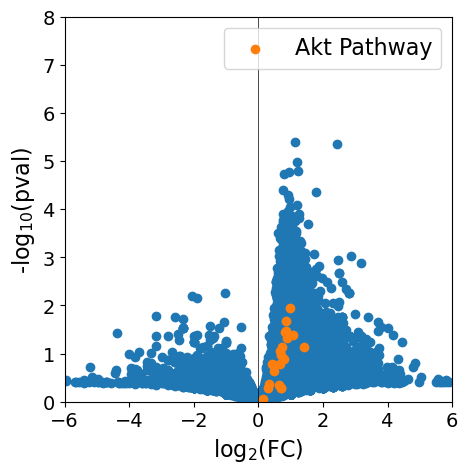

In [11]:
counts_df_sorted = counts_df.sort_values('log2FC', ascending=False)
barcode = counts_df_sorted.index.isin(akt_genes)

fig = plt.figure(figsize=(5,5))
plt.scatter(counts_df['log2FC'], -np.log10(counts_df['ttest_p']))
counts_df_slice = counts_df[counts_df.index.isin(akt_genes)]
plt.scatter(counts_df_slice['log2FC'], -np.log10(counts_df_slice['ttest_p']), label='Akt Pathway')

ax = plt.gca()
ax.set_xlim([-6,6])
ax.set_ylim([0,8])
ax.legend(fontsize=16)
ax.axvline(0, color='k', linewidth=0.5)
ax.tick_params(labelsize=14) # set the fontsize of the tick labels
ax.set_xlabel(r'log$_2$(FC)', fontsize=16)
ax.set_ylabel(r'-log$_{10}$(pval)', fontsize=16)

# enrichment score
running_sum_storage = []
running_sum = 0
running_sum_storage.append(running_sum)
n_in_pathway = np.sum(barcode)
n_not_in_pathway = len(barcode) - np.sum(barcode)
for ele in barcode:
    if ele: # gene is in gene set
        running_sum += 1/n_in_pathway
    else: # gene is not in gene set
        running_sum -= 1/n_not_in_pathway
    running_sum_storage.append(running_sum)
running_sum_storage = np.array(running_sum_storage)

es_true = running_sum_storage[np.argmax(np.abs(running_sum_storage))]
print("Since the enrichment score", es_true, "is positive, we are studying the upregulated genes from the Akt pathway.")

/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/2894474634.py:11: RuntimeWarning: divide by zero encountered in true_divide
  counts_df_2['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))
/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/2894474634.py:11: RuntimeWarning: divide by zero encountered in log2
  counts_df_2['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))


The empirical p-value of 0.5764705882352941 is above the 0.05 threshold, meaning that the set of Akt genes are not all significantly upregulated in post-Chernobyl radiation-induced pediatric thyroid cancers.


/Users/sammymustafa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


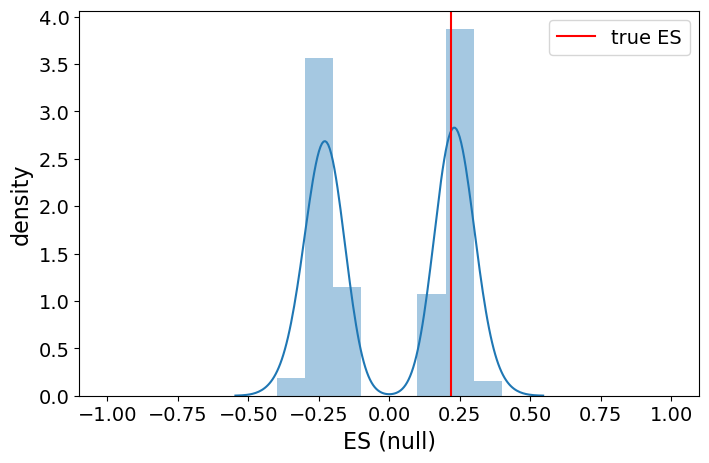

In [12]:
n_permutations = 1000
es_null_storage_array = []
for permute_n in range(n_permutations):
    new_labels = np.random.permutation(labels)

    control_vals = counts_df[sample_names[new_labels == 'control']].values
    treatment_vals = counts_df[sample_names[new_labels == 'carc']].values

    # calculate log2 fold change 
    counts_df_2 = counts_df.copy()
    counts_df_2['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))
    counts_df_2 = counts_df_2.replace([np.inf, -np.inf], np.nan)
    counts_df_2 = counts_df_2[counts_df_2["log2FC"].notnull()]
    counts_df_2_sorted = counts_df_2.sort_values('log2FC', ascending=False)

    barcode = counts_df_2_sorted.index.isin(akt_genes)

    running_sum_storage = []
    running_sum = 0
    running_sum_storage.append(running_sum)
    n_in_pathway = np.sum(barcode)
    n_not_in_pathway = len(barcode) - np.sum(barcode)
    for ele in barcode:
        if ele: # gene is in gene set
            running_sum += 1/n_in_pathway
        else: # gene is not in gene set
            running_sum -= 1/n_not_in_pathway
        running_sum_storage.append(running_sum)
    running_sum_storage = np.array(running_sum_storage)
    # get value of max deviation from zero
    es_null_storage_array.append(running_sum_storage[np.argmax(np.abs(running_sum_storage))])

es_null_storage_array = np.array(es_null_storage_array)

plt.figure(figsize=(8,5))
sns.distplot(es_null_storage_array, bins=np.arange(-1,1.01,0.1))

ax = plt.gca()
ax.axvline(es_true, color='r', label='true ES')
ax.legend(fontsize=14)
ax.set_xlabel('ES (null)', fontsize=16)
ax.set_ylabel('density', fontsize=16)
ax.tick_params(labelsize=14)

pos_es = es_null_storage_array[es_null_storage_array > 0] # get array of positive enrichment scores
print("The empirical p-value of", np.sum(pos_es >= es_true)/len(pos_es), "is above the 0.05 threshold, meaning that the set of Akt genes are not all significantly upregulated in post-Chernobyl radiation-induced pediatric thyroid cancers.")

## MAPK Pathway

Another notable pathway we can explore to identify differences in gene expression across conditions is the MAPK pathway. This list of oncogenes was obtained from Kyoto Encyclopedia of Genes and Genomes (KEGG) and includes major genes involved in the pathway like EGFR, HRAS, RAF1, and ELK4 among other notable gene modulators. 

In [13]:
mapk_json = json.load(open('pathways/KEGG_MAPK_SIGNALING_PATHWAY.v2023.1.Hs.json'))
mapk_genes = []

for gene in mapk_json['KEGG_MAPK_SIGNALING_PATHWAY']['geneSymbols']:
    mapk_genes.append(gene)
mapk_genes = ['NTRK1', 'PDGFRB', 'PDGFRA', 'JUN', 'PDGFB', 'BRAF', 'EGFR', 'NFKB2',
              'ELK4', 'NRAS', 'MECOM', 'DDIT3', 'AKT2', 'MYC', 'AKT1', 'FGFR1',
              'KRAS', 'RAF1', 'FGFR3', 'HRAS', 'FGFR2']

Since the enrichment score 0.18926902875715862 is positive, we are studying the upregulated genes from the MAPK pathway.


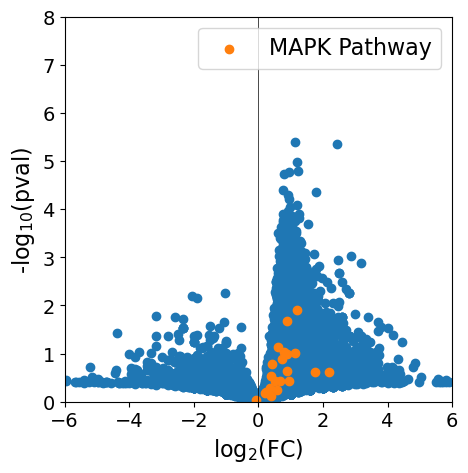

In [14]:
counts_df_sorted = counts_df.sort_values('log2FC', ascending=False)
barcode = counts_df_sorted.index.isin(mapk_genes)

fig = plt.figure(figsize=(5,5))
plt.scatter(counts_df['log2FC'], -np.log10(counts_df['ttest_p']))
counts_df_slice = counts_df[counts_df.index.isin(mapk_genes)]
plt.scatter(counts_df_slice['log2FC'], -np.log10(counts_df_slice['ttest_p']), label='MAPK Pathway')

ax = plt.gca()
ax.set_xlim([-6,6])
ax.set_ylim([0,8])
ax.legend(fontsize=16)
ax.axvline(0, color='k', linewidth=0.5)
ax.tick_params(labelsize=14) # set the fontsize of the tick labels
ax.set_xlabel(r'log$_2$(FC)', fontsize=16)
ax.set_ylabel(r'-log$_{10}$(pval)', fontsize=16)

# enrichment score
running_sum_storage = []
running_sum = 0
running_sum_storage.append(running_sum)
n_in_pathway = np.sum(barcode)
n_not_in_pathway = len(barcode) - np.sum(barcode)
for ele in barcode:
    if ele: # gene is in gene set
        running_sum += 1/n_in_pathway
    else: # gene is not in gene set
        running_sum -= 1/n_not_in_pathway
    running_sum_storage.append(running_sum)
running_sum_storage = np.array(running_sum_storage)

es_true = running_sum_storage[np.argmax(np.abs(running_sum_storage))]
print("Since the enrichment score", es_true, "is positive, we are studying the upregulated genes from the MAPK pathway.")

/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/3383215279.py:11: RuntimeWarning: divide by zero encountered in true_divide
  counts_df_3['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))
/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/3383215279.py:11: RuntimeWarning: divide by zero encountered in log2
  counts_df_3['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))


The empirical p-value of 0.279296875 is above the 0.05 threshold, meaning that the set of general thyroid cancer genes are not all significantly upregulated in post-Chernobyl radiation-induced pediatric thyroid cancers.


/Users/sammymustafa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


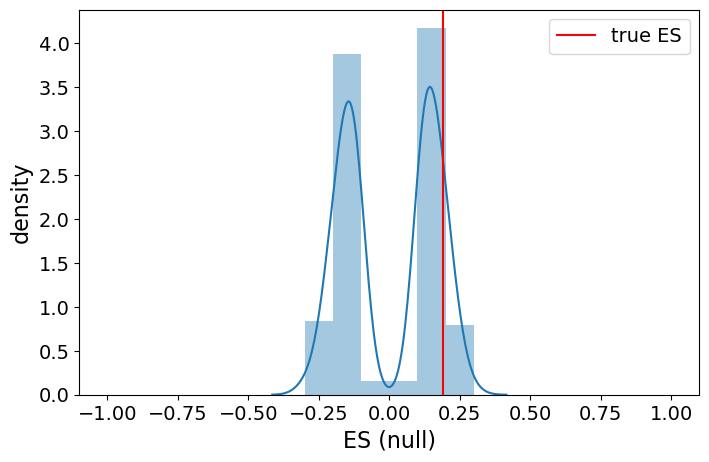

In [15]:
n_permutations = 1000
es_null_storage_array = []
for permute_n in range(n_permutations):
    new_labels = np.random.permutation(labels)

    control_vals = counts_df[sample_names[new_labels == 'control']].values
    treatment_vals = counts_df[sample_names[new_labels == 'carc']].values

    # calculate log2 fold change
    counts_df_3 = counts_df.copy()
    counts_df_3['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))
    counts_df_3 = counts_df_3.replace([np.inf, -np.inf], np.nan)
    counts_df_3 = counts_df_3[counts_df_3["log2FC"].notnull()]
    counts_df_3_sorted = counts_df_3.sort_values('log2FC', ascending=False)

    barcode = counts_df_3_sorted.index.isin(mapk_genes)

    running_sum_storage = []
    running_sum = 0
    running_sum_storage.append(running_sum)
    n_in_pathway = np.sum(barcode)
    n_not_in_pathway = len(barcode) - np.sum(barcode)
    for ele in barcode:
        if ele: # gene is in gene set
            running_sum += 1/n_in_pathway
        else: # gene is not in gene set
            running_sum -= 1/n_not_in_pathway
        running_sum_storage.append(running_sum)
    running_sum_storage = np.array(running_sum_storage)
    # get value of max deviation from zero
    es_null_storage_array.append(running_sum_storage[np.argmax(np.abs(running_sum_storage))])

es_null_storage_array = np.array(es_null_storage_array)

plt.figure(figsize=(8,5))
sns.distplot(es_null_storage_array, bins=np.arange(-1,1.01,0.1))

ax = plt.gca()
ax.axvline(es_true, color='r', label='true ES')
ax.legend(fontsize=14)
ax.set_xlabel('ES (null)', fontsize=16)
ax.set_ylabel('density', fontsize=16)
ax.tick_params(labelsize=14)

pos_es = es_null_storage_array[es_null_storage_array > 0] # get array of positive enrichment scores
print("The empirical p-value of", np.sum(pos_es >= es_true)/len(pos_es), "is above the 0.05 threshold, meaning that the set of general thyroid cancer genes are not all significantly upregulated in post-Chernobyl radiation-induced pediatric thyroid cancers.")

## Thyroid Cancer Pathway

Lastly, a more general pathway to study would be that underlying thyroid cancers. This provides a great way to test the results obtained from these more specific pathways as well as can highlight specific genes whose expression changes in thyroid cancer compared to specifically in TCs. This list of oncogenes was obtained from KEGG and includes major genes involved in the pathway like RET, TPR, TGF, and BRAF among other notable gene modulators. 

In [16]:
thyr_json = json.load(open('pathways/KEGG_THYROID_CANCER.v2023.1.Hs.json'))
thyr_genes = []

for gene in thyr_json['KEGG_THYROID_CANCER']['geneSymbols']:
    thyr_genes.append(gene)
    
thyr_genes = ['NTRK1', 'RET', 'TPM3', 'NCOA4', 'BRAF', 'NRAS', 'TFG',
              'CCND1', 'PAX8', 'MYC', 'TPR', 'CCDC6', 'CTNNB1', 'KRAS',
              'PPARG', 'HRAS']

Since the enrichment score 0.20091389114540945 is positive, we are studying the upregulated genes from the general thyroid cancer pathway.


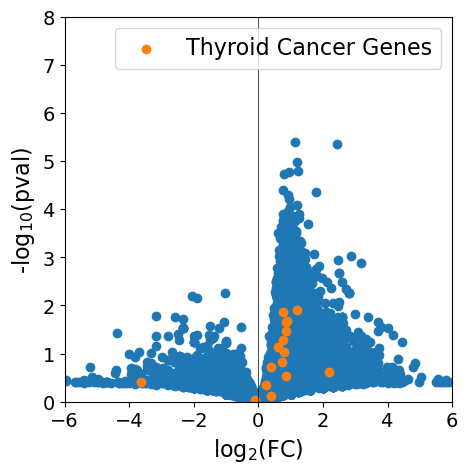

In [17]:
counts_df_sorted = counts_df.sort_values('log2FC', ascending=False)
barcode = counts_df_sorted.index.isin(thyr_genes)

fig = plt.figure(figsize=(5,5))
plt.scatter(counts_df['log2FC'], -np.log10(counts_df['ttest_p']))
counts_df_slice = counts_df[counts_df.index.isin(thyr_genes)]
plt.scatter(counts_df_slice['log2FC'], -np.log10(counts_df_slice['ttest_p']), label='Thyroid Cancer Genes')

ax = plt.gca()
ax.set_xlim([-6,6])
ax.set_ylim([0,8])
ax.legend(fontsize=16)
ax.axvline(0, color='k', linewidth=0.5)
ax.tick_params(labelsize=14) # set the fontsize of the tick labels
ax.set_xlabel(r'log$_2$(FC)', fontsize=16)
ax.set_ylabel(r'-log$_{10}$(pval)', fontsize=16)

# enrichment score
running_sum_storage = []
running_sum = 0
running_sum_storage.append(running_sum)
n_in_pathway = np.sum(barcode)
n_not_in_pathway = len(barcode) - np.sum(barcode)
for ele in barcode:
    if ele: # gene is in gene set
        running_sum += 1/n_in_pathway
    else: # gene is not in gene set
        running_sum -= 1/n_not_in_pathway
    running_sum_storage.append(running_sum)
running_sum_storage = np.array(running_sum_storage)

es_true = running_sum_storage[np.argmax(np.abs(running_sum_storage))]
print("Since the enrichment score", es_true, "is positive, we are studying the upregulated genes from the general thyroid cancer pathway.")

/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/2987786952.py:11: RuntimeWarning: divide by zero encountered in true_divide
  counts_df_4['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))
/var/folders/fz/x8jrb9ls79z2120fhg8qhh_r0000gp/T/ipykernel_13688/2987786952.py:11: RuntimeWarning: divide by zero encountered in log2
  counts_df_4['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))


The empirical p-value of 0.43687374749499 is above the 0.05 threshold, meaning that the set of general thyroid cancer genes are not all significantly upregulated in post-Chernobyl radiation-induced pediatric thyroid cancers.


/Users/sammymustafa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


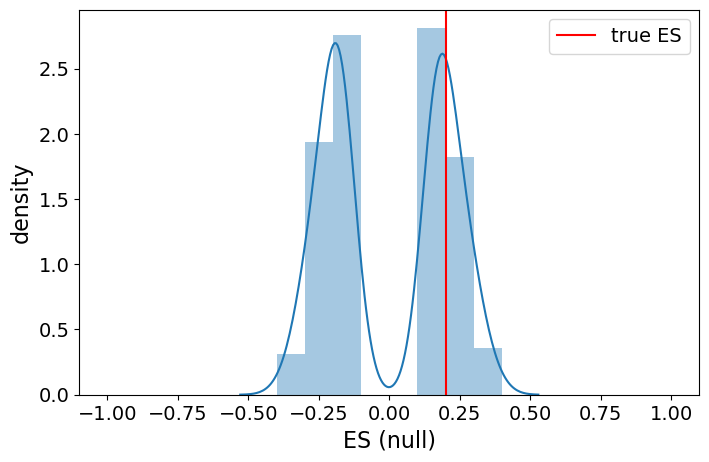

In [18]:
n_permutations = 1000
es_null_storage_array = []
for permute_n in range(n_permutations):
    new_labels = np.random.permutation(labels)

    control_vals = counts_df[sample_names[new_labels == 'control']].values
    treatment_vals = counts_df[sample_names[new_labels == 'carc']].values

    # calculate log2 fold change
    counts_df_4 = counts_df.copy()
    counts_df_4['log2FC'] = np.log2(np.mean(treatment_vals, axis=1)/np.mean(control_vals, axis=1))
    counts_df_4 = counts_df_4.replace([np.inf, -np.inf], np.nan)
    counts_df_4 = counts_df_4[counts_df_4["log2FC"].notnull()]
    counts_df_4_sorted = counts_df_4.sort_values('log2FC', ascending=False)

    barcode = counts_df_4_sorted.index.isin(thyr_genes)

    running_sum_storage = []
    running_sum = 0
    running_sum_storage.append(running_sum)
    n_in_pathway = np.sum(barcode)
    n_not_in_pathway = len(barcode) - np.sum(barcode)
    for ele in barcode:
        if ele: # gene is in gene set
            running_sum += 1/n_in_pathway
        else: # gene is not in gene set
            running_sum -= 1/n_not_in_pathway
        running_sum_storage.append(running_sum)
    running_sum_storage = np.array(running_sum_storage)
    # get value of max deviation from zero
    es_null_storage_array.append(running_sum_storage[np.argmax(np.abs(running_sum_storage))])

es_null_storage_array = np.array(es_null_storage_array)

plt.figure(figsize=(8,5))
sns.distplot(es_null_storage_array, bins=np.arange(-1,1.01,0.1))

ax = plt.gca()
ax.axvline(es_true, color='r', label='true ES')
ax.legend(fontsize=14)
ax.set_xlabel('ES (null)', fontsize=16)
ax.set_ylabel('density', fontsize=16)
ax.tick_params(labelsize=14)

pos_es = es_null_storage_array[es_null_storage_array > 0] # get array of positive enrichment scores
print("The empirical p-value of", np.sum(pos_es >= es_true)/len(pos_es), "is above the 0.05 threshold, meaning that the set of general thyroid cancer genes are not all significantly upregulated in post-Chernobyl radiation-induced pediatric thyroid cancers.")

## Conclusion

It seems like the all these pathways do not demonstrate consistent or significance in terms of their gene expression changes due to post-Chernobyl radiation-induced pediatric thyroid carcinomas. However, all the pathways did demonstrate an upregulation of gene activity from their positive enrichment scores. The MAPK pathway did have the lowest empiricial p-value so further investigation can uncover its roles in these TCs. Moreover, the study did highlight the role of MAPK activation to provide a paradigm in radiation-induced thyroid cancers so our data are on the right track. 

These results may be due to the study of fusion-oncogenes in the development of these post-Chernobyl radiation-induced pediatric TCs. The study of these genes individually may not be of as importance as the rearrangements necessary for the fusions may cause mixed results. These fusion oncogenes include RET/PTC1, ETV6-NTRK3, AGK-BRAF, CREB3L2/PPARG; while our pathways did study most of these genes, their effects alone may not be considered as theirs when fused. The radiation aspect of this project highlights the different approaches required for gene set enrichment analysis.